In [1]:
# Import necessary modules
from neo4j import GraphDatabase
from graphframes import GraphFrame
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import numpy as np
from pyspark.sql import Column
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, StructType, StructField, DoubleType, ArrayType, StringType
import pyspark.sql.functions as F
import time

# Set the URI, username, and password for the Neo4j database
uri = 'bolt://localhost:7687'
user = 'neo4j'
password = 'password'

# Create a SparkConf object with the desired configurations
conf = SparkConf().setAppName('eigs_solver') \
            .set('spark.driver.memory', '6g') \
                  .set('spark.executor.memory', '6g') \
                  .set('spark.executor.cores', '8') \
                  .set('spark.rdd.compress', 'True')


# Create a SparkSession with the Neo4j configuration and the SparkConf object
spark = SparkSession.builder.appName('eigs_solver') \
    .config('spark.jars.packages', 'org.neo4j:neo4j-connector-apache-spark_2.12:5.0.0_for_spark_3,graphframes:graphframes:0.8.0-spark3.0-s_2.12') \
    .config('spark.neo4j.bolt.url', uri) \
    .config('spark.neo4j.bolt.user', user) \
    .config('spark.neo4j.bolt.password', password) \
    .config(conf=conf) \
    .getOrCreate()

# Query for the vertices that match the filter
vertices = spark.read.format("org.neo4j.spark.DataSource") \
    .option("url", uri) \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option('query','''MATCH (n)
                        RETURN id(n) as id''') \
    .load()

# Query for the edges that connect the specified vertices
edges = spark.read.format("org.neo4j.spark.DataSource") \
    .option("url", uri) \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option("query", """MATCH (n1) --(n2)
                        WITH id(n1) as src, id(n2) as dst
                        RETURN src, dst""") \
    .load()

# # for Offshore DBMS
# # Query for the vertices that match the filter
# vertices = spark.read.format("org.neo4j.spark.DataSource") \
#     .option("url", uri) \
#     .option("authentication.basic.username", user) \
#     .option("authentication.basic.password", password) \
#     .option('query','''MATCH (n:OFFICER)--(o)
#                         WHERE n.countries = "United States"
#                         WITH COLLECT(DISTINCT id(n)) + COLLECT(DISTINCT id(o)) as vertex_ids
#                         MATCH (n)
#                         WHERE id(n) in vertex_ids
#                         WITH n.name as name, id(n) as id
#                         RETURN name, id''') \
#     .load()

# # Query for the edges that connect the specified vertices
# edges = spark.read.format("org.neo4j.spark.DataSource") \
#     .option("url", uri) \
#     .option("authentication.basic.username", user) \
#     .option("authentication.basic.password", password) \
#     .option("query", """MATCH (n:OFFICER)--(o)
#                         WHERE n.countries = "United States"
#                         WITH COLLECT(DISTINCT id(n)) + COLLECT( DISTINCT id(o)) as vertex_ids
#                         MATCH (n1)--(n2)
#                         WHERE id(n1) IN vertex_ids AND id(n2) in vertex_ids
#                         WITH id(n1) as src, id(n2) as dst
#                         RETURN src, dst""") \
#     .load()


# Create a GraphFrame object using the vertices and edges DataFrame
graph = GraphFrame(vertices, edges)

23/03/31 15:52:12 WARN Utils: Your hostname, Michaels-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.202.7.66 instead (on interface en0)
23/03/31 15:52:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/michaelroth/miniforge3/envs/golden_torch/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/michaelroth/.ivy2/cache
The jars for the packages stored in: /Users/michaelroth/.ivy2/jars
org.neo4j#neo4j-connector-apache-spark_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7d3aee43-3cef-4d01-95f7-033327adc5b5;1.0
	confs: [default]
	found org.neo4j#neo4j-connector-apache-spark_2.12;5.0.0_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.12_common;5.0.0 in central
	found org.neo4j.driver#neo4j-java-driver;4.4.9 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found org.apache.xbean#xbean-asm6-shaded;4.10 in central
	found org.neo4j#neo4j-cypher-dsl;2020.1.4 in central
	found org.apiguardian#apiguardian-api;1.1.0 in central
	found graphframes#graphframes;0.8.0-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 583ms :: artifacts dl 43ms
	:: modules in use:
	

23/03/31 15:52:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/Users/michaelroth/miniforge3/envs/golden_torch/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [2]:
# Create a variable edge_data that contains the graph.edges data
edge_data = graph.edges

# Construct the adjacency matrix as a DataFrame
adjacency_matrix = edge_data.selectExpr("src as i", "dst as j", "1 as value") \
                            .distinct().sort('i', 'j')

# Construct the degree matrix as a DataFrame
degree_matrix = adjacency_matrix.groupby('i') \
                                .sum('value') \
                                .withColumn('j', col('i')) \
                                .select('i', 'j', 'sum(value)') \
                                .withColumnRenamed('sum(value)', 'value') \
                                .sort('i')

# Get n number of total nodes in the complete graph
n = degree_matrix.selectExpr('MAX(i) AS n').first().n + 1

# Compute the Laplacian matrix as a RDD
laplacian_matrix = degree_matrix.union(adjacency_matrix) \
            .withColumn("laplacian", col("value") * (F.when(col('i') == col('j'), 1).otherwise(-1))) \
            .select('i', 'j', 'laplacian')


In [3]:
num_partitions = 1

laplacian_rdd = laplacian_matrix.rdd.map(lambda x: (x.i, (x.j, x.laplacian))).repartition(num_partitions)

In [4]:
from pyspark_eigensolver import eig_rdd

In [5]:
k = 10

eigvals_rdd, eigvecs_rdd = eig_rdd(laplacian_rdd, num_partitions, k=k, num_restarts=5)


Restart 0 



step:10, Avg. Iteration: 1.18 s, Time Left: 0.02 min. <========================================> 100.00%    
Restart 1 

step:10, Avg. Iteration: 0.91 s, Time Left: 0.02 min. <========================================> 100.00%    
Restart 2 

step:10, Avg. Iteration: 0.77 s, Time Left: 0.01 min. <========================================> 100.00%    
Restart 3 

step:10, Avg. Iteration: 0.77 s, Time Left: 0.01 min. <========================================> 100.00%    
Restart 4 



In [6]:
from pyspark_eigensolver import rdd_to_numpy

eigvecs_np = rdd_to_numpy(eigvecs_rdd, n_j=k)

In [7]:
eigvecs_np.shape

(179, 10)

In [8]:
import plotly.express as px

# Filter the eigenvectors array based on the sum along axis 1
filtered_eigvecs = eigvecs_np[:, :3]

# Create a 3D scatter plot using Plotly Express
fig = px.scatter_3d(
    x=filtered_eigvecs[:, 0],
    y=filtered_eigvecs[:, 1],
    z=filtered_eigvecs[:, 2],
    text=range(len(filtered_eigvecs))
)

# Show the plot
fig.show()

In [9]:
from scipy.linalg import eig

true_eigvals, true_eigvectors = eig(rdd_to_numpy(laplacian_rdd))

In [10]:
true_eigvals, true_eigvectors = true_eigvals[np.argsort(true_eigvals)], true_eigvectors[np.argsort(true_eigvals)]

In [11]:
eigvals_np = rdd_to_numpy(eigvals_rdd.mapValues(lambda x: (0, x)))[:, 0]

/Users/michaelroth/miniforge3/envs/golden_torch/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning:

Casting complex values to real discards the imaginary part



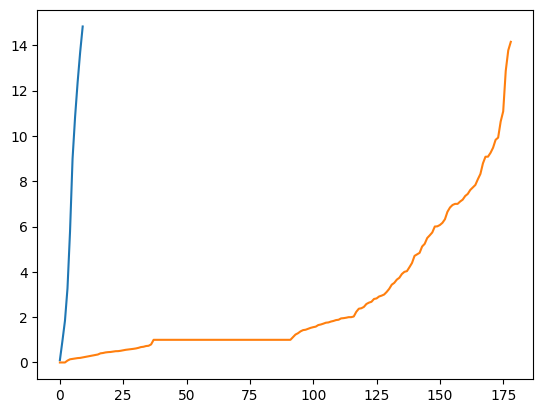

In [12]:
import matplotlib.pyplot as plt

plt.plot(sorted(eigvals_np), label='T')
plt.plot(true_eigvals, label='A')


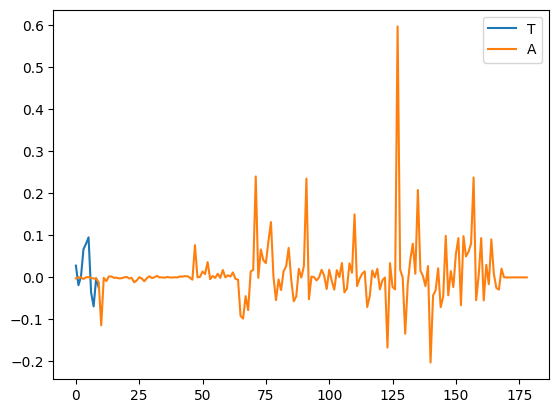

In [13]:
i = 0

plt.plot(eigvecs_np[np.argsort(eigvals_np)][i], label='T')
plt.plot(true_eigvectors[i], label='A')
plt.legend()
plt.show()